In [1]:
import os
import wget
import gzip
import math
import matplotlib.pyplot as plt
import random
import scipy
import tensorflow as tf
import torch
from torch import nn
from collections import defaultdict
from implicit import bpr
from scipy.spatial import distance


Data is available at http://cseweb.ucsd.edu/~jmcauley/pml/data/. 
- Download and save to your own directory.
- Or, run following script to save it into `Chapter_10/data` folder automatically.

In [2]:
filenames = [
    'goodreads_reviews_comics_graphic.json.gz',
    'beer.json.gz'
]

dataDir = './data'
url = 'http://jmcauley.ucsd.edu/pml_data'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
for filename in filenames:
    wget.download(os.path.join(url, filename), out=dataDir)

print("Done!")


Done!


# Basic fairness measurements - interaction and recommendation distributions

Goodreads graphic novel data. Train a standard recommender, and compare generated recommendations to historical interactions, in terms of frequency distributions.

In [3]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)


In [4]:
data = []
for x in parse(os.path.join(dataDir, "goodreads_reviews_comics_graphic.json.gz")):
    del x['review_text']
    data.append(x)


In [5]:
random.shuffle(data)


In [6]:
userIDs, itemIDs = {}, {}
revUIDs, revIIDs = {}, {}
for d in data:
    u, i = d['user_id'], d['book_id']
    if not u in userIDs:
        userIDs[u] = len(userIDs)
        revUIDs[userIDs[u]] = u
    if not i in itemIDs:
        itemIDs[i] = len(itemIDs)
        revIIDs[itemIDs[i]] = i


In [7]:
nUsers, nItems = len(userIDs), len(itemIDs)
nUsers, nItems


(59347, 89311)

Problem setup follows the BPR library from "implicit" (see Chapter 5), but could be completed with any recommender

In [8]:
Xiu = scipy.sparse.lil_matrix((nItems, nUsers))
for d in data:
    Xiu[itemIDs[d['book_id']], userIDs[d['user_id']]] = 1

Xui = scipy.sparse.csr_matrix(Xiu.T)


In [9]:
model = bpr.BayesianPersonalizedRanking(factors=5, use_gpu=False)


Fit the model

In [10]:
model.fit(Xiu)


  0%|          | 0/100 [00:00<?, ?it/s]

Extract recommendations (example)

In [11]:
model.recommend(0, Xui)


[(276, 5.194048),
 (1126, 5.139212),
 (8206, 5.1298647),
 (4425, 5.125072),
 (818, 5.1217484),
 (2108, 5.121192),
 (251, 5.0484858),
 (835, 5.0297604),
 (5399, 4.982141),
 (333, 4.932531)]

Next we extract recommendations for all users, and compare these to their interaction histories. First collect histories from historical trends:

In [12]:
interactionTuples = []
itemsPerUser = defaultdict(list)


In [13]:
for d in data:
    u, i = d['user_id'], d['book_id']
    interactionTuples.append((userIDs[u], itemIDs[i]))
    itemsPerUser[userIDs[u]].append(itemIDs[i])


Next build similar data structures containing recommendations for each user

In [14]:
recommendationTuples = []


For each user, generate a set of recommendations equivalent in size to their number of interactions used for training

In [15]:
for u in range(len(userIDs)):
    A = model.recommend(u, Xui, N=len(itemsPerUser[u]))
    for i, sc in A:
        recommendationTuples.append((u, i))


So far our data structures just contain lists of historical interactions and recommendations for each user. Convert these into counts for each item. This is done both for interactions (I) and recommendations (R).

In [16]:
countsPerItemI = defaultdict(int)
countsPerItemR = defaultdict(int)
for u, i in interactionTuples:
    countsPerItemI[i] += 1

for u, i in recommendationTuples:
    countsPerItemR[i] += 1


Sort counts by popularity to generate plots

In [17]:
sortPopularI = [(countsPerItemI[i], i) for i in countsPerItemI]
sortPopularR = [(countsPerItemR[i], i) for i in countsPerItemR]


In [18]:
sortPopularI.sort(reverse=True)
sortPopularR.sort(reverse=True)


Collect the information for interactions and recommendations for plotting

In [19]:
YI = [x[0] for x in sortPopularI[:300]]  # Interaction frequency
Ys = [x[1] for x in sortPopularI[:300]]  # Associated items
# Recommendation frequency for those items
YR = [countsPerItemR[x] for x in Ys]


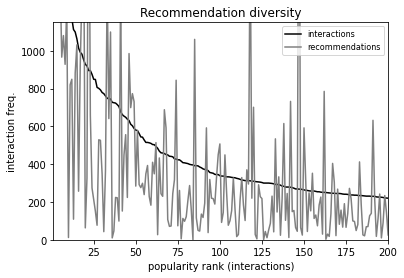

In [20]:
plt.plot(range(1, 301), YI, color='k', label="interactions")
plt.xlim(1, 200)
plt.ylim(0, 1150)
plt.plot(range(1, 301), YR, color='grey', label="recommendations")
plt.xlabel("popularity rank (interactions)")
plt.ylabel("interaction freq.")
plt.legend(loc="best",  prop={'size': 8})
plt.title("Recommendation diversity")
plt.show()


In [21]:
YR = [x[0] for x in sortPopularR[:300]]
Ys = [x[1] for x in sortPopularR[:300]]
YI = [countsPerItemI[x] for x in Ys]


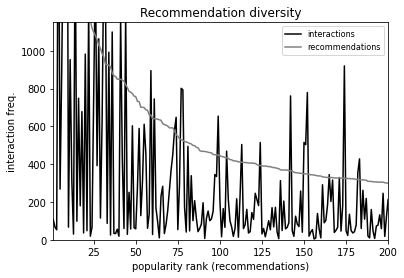

In [22]:
plt.plot(range(1, 301), YI, color='k', label="interactions")
plt.xlim(1, 200)
plt.ylim(0, 1150)
plt.plot(range(1, 301), YR, color='grey', label="recommendations")
plt.xlabel("popularity rank (recommendations)")
plt.ylabel("interaction freq.")
plt.legend(loc="best",  prop={'size': 8})
plt.title("Recommendation diversity")
plt.show()


# Gini goefficient

The two implementations below compute the gini coefficient either by comparing all pairs, or by doing so for a given number of samples

In [23]:
def gini(z, samples=1000000):
    m = sum(z) / len(z)
    denom = 2 * samples * m
    numer = 0
    for _ in range(samples):
        i = random.choice(z)
        j = random.choice(z)
        numer += math.fabs(i - j)
    return numer / denom


def giniExact(z):
    m = sum(z) / len(z)
    denom = 2 * len(z)**2 * m
    numer = 0
    for i in range(len(z)):
        for j in range(len(z)):
            numer += math.fabs(z[i] - z[j])
    return numer / denom


Compute the gini coefficients of interactions versus distributions for the two distributions computed in the experiments above

In [24]:
gini([x[0] for x in sortPopularI])


0.7208938820228343

In [25]:
gini([x[0] for x in sortPopularR])


0.778433054089885

### Average cosine similarity between interactions versus recommendations

Given a set of items, measure the average cosine distance between them (by taking a sample of pairs, similar to our implementation of the gini coefficient). This can be used as a rough measure of the diversity of a set of recommendations.

In [26]:
def avCosine(z, samples=100):
    av = []
    while len(av) < samples:
        i = random.choice(z)
        j = random.choice(z)
        d = 1 - distance.cosine(i, j)
        if not math.isnan(d) and d > 0:
            av.append(d)
    return sum(av) / len(av)


In [27]:
itemFactors = model.item_factors


Compute the average cosine similarity among interactions from a particular user

In [28]:
avCosine([itemFactors[i] for i in itemsPerUser[0]])


0.6360789451375604

Compute the same quantity across a large sample of recommendations and interactions for several users, as an aggregate measure of recommendation versus interaction diversity

In [29]:
avavI = []
avavR = []

while len(avavI) < 1000:
    u = random.choice(range(len(userIDs)))
    if len(itemsPerUser[u]) < 10:
        continue
    aI = avCosine([itemFactors[i] for i in itemsPerUser[u]])
    A = model.recommend(u, Xui, N=len(itemsPerUser[u]))
    aR = avCosine([itemFactors[i[0]] for i in A])
    avavI.append(aI)
    avavR.append(aR)


A lower average cosine similarity among interactions indicates that they are more diverse compared to recommendations

In [30]:
sum(avavI) / len(avavI)


0.622365073144189

In [31]:
sum(avavR) / len(avavR)


0.8621030857469554

# Fair recommendation in `TensorFlow` and `PyTorch`

## Dataset Preparation

First, implement a latent factor model. Our basic implementation follows the Tensorflow latent factor model from Chapter 5.

In [32]:
userIDs = {}
itemIDs = {}
itemsPerUser = defaultdict(set)
styles = {}
beerNames = {}
interactions = []

for d in parse(os.path.join(dataDir, "beer.json.gz")):
    if not 'user/gender' in d:
        continue
    g = d['user/gender'] == 'Male'
    u = d['user/profileName']
    i = d['beer/beerId']
    r = d['review/overall']
    styles[i] = d['beer/style']
    beerNames[i] = d['beer/name']
    if not u in userIDs:
        userIDs[u] = len(userIDs)
    if not i in itemIDs:
        itemIDs[i] = len(itemIDs)
    itemsPerUser[u].add(i)
    interactions.append((g, u, i, r))


In [33]:
len(interactions)


637221

Data structures to organize interactions by gender

In [34]:
interactionsPerItemG = defaultdict(list)  # Male interactions
interactionsPerItemGneg = defaultdict(list)  # Other interactions


In [35]:
for g, u, i, r in interactions:
    if g:
        # Male interactions for this item
        interactionsPerItemG[i].append((u, r))
    else:
        interactionsPerItemGneg[i].append((u, r))


In [36]:
# Set of items associated with male interactions
itemsG = set(interactionsPerItemG.keys())
itemsGneg = set(interactionsPerItemGneg.keys())
itemsBoth = itemsG.intersection(itemsGneg)


In [37]:
mu = sum([r for _, _, _, r in interactions]) / \
    len(interactions)  # For initialization


## `TensorFlow` Implementation

In [38]:
optimizer = tf.keras.optimizers.Adam(0.1)


Latent factor model. The "absoluteFairness" function is new; others are equivalent to our model from Chapter 5.

In [39]:
class LatentFactorModel(tf.keras.Model):
    def __init__(self, mu, K, lamb, lambFair):
        super(LatentFactorModel, self).__init__()
        self.alpha = tf.Variable(mu)
        self.betaU = tf.Variable(
            tf.random.normal([len(userIDs)], stddev=0.001))
        self.betaI = tf.Variable(
            tf.random.normal([len(itemIDs)], stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal(
            [len(userIDs), K], stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal(
            [len(itemIDs), K], stddev=0.001))
        self.lamb = lamb
        self.lambFair = lambFair

    def predict(self, u, i):
        p = self.alpha + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    def reg(self):
        return self.lamb * (tf.reduce_sum(self.betaU**2) +
                            tf.reduce_sum(self.betaI**2) +
                            tf.reduce_sum(self.gammaU**2) +
                            tf.reduce_sum(self.gammaI**2))

    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        pred = self.alpha + beta_u + beta_i +\
            tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return pred

    # For a single item. This score should be averaged over several items
    def absoluteUnfairness(self, i):
        G = interactionsPerItemG[i]
        Gneg = interactionsPerItemGneg[i]
        # interactions take the form (u,r)
        rG = tf.reduce_mean(tf.convert_to_tensor([r for _, r in G]))
        rGneg = tf.reduce_mean(tf.convert_to_tensor([r for _, r in Gneg]))
        pG = tf.reduce_mean(
            self.predictSample([userIDs[u] for u, _ in G], [itemIDs[i]]*len(G)))
        pGneg = tf.reduce_mean(
            self.predictSample([userIDs[u] for u, _ in Gneg], [itemIDs[i]]*len(Gneg)))
        Uabs = tf.abs(tf.abs(pG - rG) - tf.abs(pGneg - rGneg))
        return self.lambFair * Uabs

    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)
        return tf.nn.l2_loss(pred - r) / len(sampleR)


In [40]:
modelFair = LatentFactorModel(mu, 10, 0.000001, 0.000001)


2022-03-24 16:30:36.433541: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-24 16:30:36.433576: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Zhankui
2022-03-24 16:30:36.433580: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Zhankui
2022-03-24 16:30:36.433702: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-03-24 16:30:36.433718: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-03-24 16:30:36.433722: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-03-24 16:30:36.434036: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in

In [41]:
def trainingStep(model, interactions):
    Nsamples = 5000
    Nfair = 50
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples):
            _, u, i, r = random.choice(interactions)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

        loss = model(sampleU, sampleI, sampleR)
        loss += sum([model.absoluteUnfairness(i)
                     for i in random.sample(itemsBoth, Nfair)])/Nfair
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(
                                  gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()


In [42]:
for i in range(100):
    obj = trainingStep(modelFair, interactions)
    if (i % 50 == 49):
        print("iteration " + str(i+1) + ", objective = " + str(obj))


iteration 50, objective = 0.26605088
iteration 100, objective = 0.28741658


Same model, but not including the fairness terms

In [43]:
modelUnfair = LatentFactorModel(mu, 10, 0.000001, 0.000001)


In [44]:
def trainingStepUnfair(model, interactions):
    Nsamples = 5000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples):
            _, u, i, r = random.choice(interactions)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

        loss = model(sampleU, sampleI, sampleR)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(
                                  gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()


In [45]:
for i in range(100):
    obj = trainingStepUnfair(modelUnfair, interactions)
    if (i % 50 == 49):
        print("iteration " + str(i+1) + ", objective = " + str(obj))


iteration 50, objective = 0.5806019
iteration 100, objective = 0.42937765


# Maximal marginal relevance (MMR)

Similarity between items (in this case cosine)

In [46]:
def cosine(v, w):
    return float(tf.reduce_sum(v*w, 0) / (tf.norm(v) * tf.norm(w)))


In [47]:
def sim(itemEmbeddings, i, j):
    gamma_i = itemEmbeddings[i]
    gamma_j = itemEmbeddings[j]
    return cosine(gamma_i, gamma_j)


Find the most similar item among a candidate set

In [48]:
def maxSim(itemEmbeddings, i, seq):
    if len(seq) == 0:
        return 0
    return max([sim(itemEmbeddings, i, j) for j in seq])


Select a random user to receive recommendations

In [49]:
u = random.choice(list(userIDs.keys()))


In [50]:
itemSet = set(itemIDs.keys())


Define a function to get the next recommendation given an initial list, i.e., the mamimal marginally relevant item. Lambda (lamb) controls the tradeoff between compatibility an diversity.

In [51]:
def getNextRec(model, compatScores, itemEmbeddings, seq, lamb):
    scores = [(lamb * s - (1 - lamb) * maxSim(itemEmbeddings, i, seq), i)
              for (s, i) in compatScores if not i in seq]
    (maxScore, maxItem) = max(scores)
    return maxItem


Before re-ranking, generate a list of compatibility scores, i.e., a ranked list of items for a particular user

In [52]:
candidates = list(itemSet.difference(itemsPerUser[u]))
compatScores = list(zip([float(f)
                         for f in modelUnfair.predictSample([userIDs[u]]*len(candidates),
                                                            [itemIDs[i] for i in candidates])], candidates))
itemEmbeddings = dict(zip(candidates,
                          tf.nn.embedding_lookup(modelUnfair.gammaI, [itemIDs[i] for i in candidates])))

compatScores.sort(reverse=True)


Generate a list of recommendations for the user by repeatedly calling the retrieving the maximal marginally relevant recommendation. First, just get the most relevant items (lambda=1) without encouraging diversity.

Note that this implementation is not particularly optimized, and takes several seconds to generate a list of recommendations.

In [53]:
recs = []
while len(recs) < 10:
    i = getNextRec(modelUnfair, compatScores[:1000], itemEmbeddings, recs, 1.0)
    recs.append(i)
[beerNames[i] for i in recs]


['Black IPA',
 'Kriekselikroxen',
 'Habanero Stout',
 'Bolero Brown',
 'Slice Of Bread',
 'Kazbegi Hunter Lager',
 'Riot',
 'Chamomile Wheat',
 'Summer Bitter',
 'Smoked & Oaked']

More Recommendations for different relevance/diversity tradeoffs. Note that the tradeoff parameter is quite sensitive to the specific scale of the model parameters.

In [54]:
recs = []
while len(recs) < 10:
    i = getNextRec(model, compatScores[:1000], itemEmbeddings, recs, 0.25)
    recs.append(i)
[beerNames[i] for i in recs]


['Black IPA',
 'X.O. Tripplebock',
 'Chamomile Wheat',
 'Smoked & Oaked',
 "Brewer's Reserve Old Godfather Barley Wine",
 'Riot',
 'Kriekselikroxen',
 'Bolero Brown',
 'Unibroue 17 Grande RÃ©serve',
 'Habanero Stout']

In [55]:
recs = []
while len(recs) < 10:
    i = getNextRec(model, compatScores[:1000], itemEmbeddings, recs, 0.1)
    recs.append(i)
[beerNames[i] for i in recs]


['Black IPA',
 'X.O. Tripplebock',
 'Brecky',
 'Frostnipper Winter Warmer',
 'Chamomile Wheat',
 'Nut Brown Ale',
 "Down 'N Dirty Chocolate Oatmeal Stout",
 'Black Magic Porter',
 'Spring Ale',
 "Bishop's Farewell"]

# Exercises

### 10.1

First just try out a different similarity function (based on the inner product)

In [56]:
def sim(itemEmbeddings, i, j):
    gamma_i = itemEmbeddings[i]
    gamma_j = itemEmbeddings[j]
    return tf.sigmoid(-tf.reduce_sum(gamma_i * gamma_j, 0)).numpy()


In [57]:
def maxSim(itemEmbeddings, i, seq):
    if len(seq) == 0:
        return 0
    return max([sim(itemEmbeddings, i, j) for j in seq])


In [58]:
def getNextRec(model, compatScores, itemEmbeddings, seq, lamb):
    rels = dict([(i, s) for (s, i) in compatScores if not i in seq])
    divs = dict([(i, maxSim(itemEmbeddings, i, seq))
                for (s, i) in compatScores if not i in seq])
    scores = [(lamb * rels[i] - (1 - lamb) * divs[i], i)
              for (s, i) in compatScores if not i in seq]
    (maxScore, maxItem) = max(scores)
    return rels[maxItem], divs[maxItem], maxItem


In [59]:
u = random.choice(list(userIDs.keys()))


In [60]:
candidates = list(itemSet.difference(itemsPerUser[u]))
compatScores = list(zip([float(f)
                         for f in modelUnfair.predictSample([userIDs[u]]*len(candidates),
                                                            [itemIDs[i] for i in candidates])], candidates))
itemEmbeddings = dict(zip(candidates,
                          tf.nn.embedding_lookup(modelUnfair.gammaI, [itemIDs[i] for i in candidates])))

compatScores.sort(reverse=True)


Experiment with different relevance/diversity tradeoffs

In [61]:
xs = []
ys = []
for lamb in [1.0, 0.99, 0.9, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001]:
    rels = []
    divs = []
    recs = []
    while len(recs) < 5:
        r, d, i = getNextRec(
            modelUnfair, compatScores[:1000], itemEmbeddings, recs, lamb)
        rels.append(r)
        divs.append(d)
        recs.append(i)
    xs.append(sum(rels)/len(rels))
    ys.append(sum(divs)/len(divs))


And plot the results

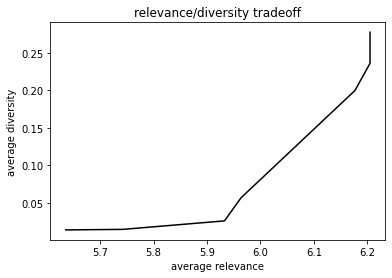

In [62]:
plt.plot(xs, ys, color='k')
plt.xlabel("average relevance")
plt.ylabel("average diversity")
plt.title("relevance/diversity tradeoff")
plt.show()


## `PyTorch` Implementation

In [63]:
class LatentFactorModel(nn.Module):
    def __init__(self, mu, K, lamb, lambFair):
        super(LatentFactorModel, self).__init__()
        # Initialize to average
        self.alpha = nn.Parameter(torch.Tensor([mu]))
        # Initialize to small random values
        self.betaU = nn.Embedding(len(userIDs), 1)
        nn.init.normal_(self.betaU.weight, std=0.001)
        self.betaI = nn.Embedding(len(itemIDs), 1)
        nn.init.normal_(self.betaI.weight, std=0.001)
        self.gammaU = nn.Embedding(len(userIDs), K)
        nn.init.normal_(self.gammaU.weight, std=0.001)
        self.gammaI = nn.Embedding(len(itemIDs), K)
        nn.init.normal_(self.gammaI.weight, std=0.001)
        self.lamb = lamb
        self.lambFair = lambFair

    # Prediction
    def forward(self, u, i):
        p = self.alpha + self.betaU(u).squeeze(-1) + self.betaI(i).squeeze(-1) + \
            (self.gammaU(u) * self.gammaI(i)).sum(dim=-1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (torch.sum(self.betaU.weight**2) +
                            torch.sum(self.betaI.weight**2) +
                            torch.sum(self.gammaU.weight**2) +
                            torch.sum(self.gammaI.weight**2))

    # For a single item. This score should be averaged over several items
    def absoluteUnfairness(self, i):
        G = interactionsPerItemG[i]
        Gneg = interactionsPerItemGneg[i]
        # interactions take the form (u,r)
        rG = torch.Tensor([r for _, r in G]).mean()
        rGneg = torch.Tensor([r for _, r in Gneg]).mean()
        pG = self.forward(torch.LongTensor(
            [userIDs[u] for u, _ in G]), torch.LongTensor([itemIDs[i]]*len(G))).mean()
        pGneg = self.forward(torch.LongTensor(
            [userIDs[u] for u, _ in Gneg]), torch.LongTensor([itemIDs[i]]*len(Gneg))).mean()
        Uabs = torch.abs(torch.abs(pG - rG) - torch.abs(pGneg - rGneg))
        return self.lambFair * Uabs

    # Loss
    def loss(self, u, i, r):
        pred = self.forward(u, i)
        # mse_loss in pytorch is 2 * l2_loss in tensorflow
        return nn.functional.mse_loss(pred, r) + self.reg()


In [64]:
modelFair = LatentFactorModel(mu, 10, 0.000001, 0.000001)
optimizer = torch.optim.Adam(modelFair.parameters(), lr=0.1)


In [65]:
def trainingStep(model, interactions):
    # gradient reset
    optimizer.zero_grad()
    # data generation
    Nsamples = 50000
    Nfair = 50
    sampleU, sampleI, sampleR = [], [], []
    for _ in range(Nsamples):
        _, u, i, r = random.choice(interactions)
        sampleU.append(userIDs[u])
        sampleI.append(itemIDs[i])
        sampleR.append(r)
    sampleU, sampleI, sampleR = torch.LongTensor(
        sampleU), torch.LongTensor(sampleI), torch.Tensor(sampleR)
    # loss calculation
    loss = model.loss(sampleU, sampleI, sampleR)
    loss += sum([model.absoluteUnfairness(i)
                for i in random.sample(itemsBoth, Nfair)]) / Nfair
    # gradient calculation
    loss.backward()
    # weight update
    optimizer.step()
    return loss.item()


In [66]:
for i in range(100):
    loss = trainingStep(modelFair, interactions)
    if (i % 10 == 9):
        print("iteration " + str(i+1) + ", loss = " + str(loss))


iteration 10, loss = 0.37620335817337036
iteration 20, loss = 0.3431888222694397
iteration 30, loss = 0.32452094554901123
iteration 40, loss = 0.3099097013473511
iteration 50, loss = 0.30067178606987
iteration 60, loss = 0.29872679710388184
iteration 70, loss = 0.2932773232460022
iteration 80, loss = 0.2935100197792053
iteration 90, loss = 0.29322904348373413
iteration 100, loss = 0.2934666574001312


Same model, but not including the fairness terms

In [67]:
modelUnfair = LatentFactorModel(mu, 10, 0.000001, 0.000001)
optimizer = torch.optim.Adam(modelUnfair.parameters(), lr=0.1)


In [68]:
def trainingStepUnfair(model, interactions):
    # gradient reset
    optimizer.zero_grad()
    # data generation
    Nsamples = 50000
    sampleU, sampleI, sampleR = [], [], []
    for _ in range(Nsamples):
        _, u, i, r = random.choice(interactions)
        sampleU.append(userIDs[u])
        sampleI.append(itemIDs[i])
        sampleR.append(r)
    sampleU, sampleI, sampleR = torch.LongTensor(
        sampleU), torch.LongTensor(sampleI), torch.Tensor(sampleR)
    # loss calculation
    loss = model.loss(sampleU, sampleI, sampleR)
    # gradient calculation
    loss.backward()
    # weight update
    optimizer.step()
    return loss.item()


for i in range(100):
    obj = trainingStepUnfair(modelUnfair, interactions)
    if (i % 10 == 9):
        print("iteration " + str(i+1) + ", objective = " + str(obj))


iteration 10, objective = 0.3729541003704071
iteration 20, objective = 0.3486887514591217
iteration 30, objective = 0.32848846912384033
iteration 40, objective = 0.31049981713294983
iteration 50, objective = 0.2988719046115875
iteration 60, objective = 0.2990160286426544
iteration 70, objective = 0.2929946780204773
iteration 80, objective = 0.2937666177749634
iteration 90, objective = 0.2894299030303955
iteration 100, objective = 0.2935916781425476


# Maximal marginal relevance (MMR)

Similarity between items (in this case cosine)

In [69]:
def cosine(v, w):
    return (torch.sum(v * w, dim=-1) / (torch.norm(v) * torch.norm(w))).item()


def sim(itemEmbeddings, i, j):
    gamma_i = itemEmbeddings[i]
    gamma_j = itemEmbeddings[j]
    return cosine(gamma_i, gamma_j)


Find the most similar item among a candidate set

In [70]:
def maxSim(itemEmbeddings, i, seq):
    if len(seq) == 0:
        return 0
    return max([sim(itemEmbeddings, i, j) for j in seq])


Select a random user to receive recommendations

In [71]:
u = random.choice(list(userIDs.keys()))
itemSet = set(itemIDs.keys())


Define a function to get the next recommendation given an initial list, i.e., the mamimal marginally relevant item. Lambda (lamb) controls the tradeoff between compatibility an diversity.

In [72]:
def getNextRec(model, compatScores, itemEmbeddings, seq, lamb):
    scores = [(lamb * s - (1 - lamb) * maxSim(itemEmbeddings, i, seq), i)
              for (s, i) in compatScores if not i in seq]
    (maxScore, maxItem) = max(scores)
    return maxItem


Before re-ranking, generate a list of compatibility scores, i.e., a ranked list of items for a particular user

In [73]:
candidates = list(itemSet.difference(itemsPerUser[u]))
compatScores = list(zip([float(f)
                         for f in modelUnfair(torch.LongTensor([userIDs[u]]*len(candidates)),
                         torch.LongTensor([itemIDs[i] for i in candidates]))], candidates))
itemEmbeddings = dict(zip(candidates,
                          modelUnfair.gammaI.weight.data[[itemIDs[i] for i in candidates]]))

compatScores.sort(reverse=True)


Generate a list of recommendations for the user by repeatedly calling the retrieving the maximal marginally relevant recommendation. First, just get the most relevant items (lambda=1) without encouraging diversity.

Note that this implementation is not particularly optimized, and takes several seconds to generate a list of recommendations.

In [74]:
recs = []
while len(recs) < 10:
    i = getNextRec(modelUnfair, compatScores[:1000], itemEmbeddings, recs, 1.0)
    recs.append(i)
[beerNames[i] for i in recs]


['Oatmeal Stout',
 'Dave',
 'Terrapin Oak Aged Wake-n-Bake Coffee Oatmeal Imperial Stout',
 'Josiah Miller IPA',
 'Killer Bee',
 'XXXX Quad',
 'Rare Bourbon County Stout',
 'Penguin XX Imperial Stout',
 'Boyne River Brown Ale',
 "Lips Of Faith - Eric's Ale (Bourbon Barrel Aged)"]

More Recommendations for different relevance/diversity tradeoffs. Note that the tradeoff parameter is quite sensitive to the specific scale of the model parameters.

In [75]:
recs = []
while len(recs) < 10:
    i = getNextRec(model, compatScores[:1000], itemEmbeddings, recs, 0.25)
    recs.append(i)
[beerNames[i] for i in recs]


['Oatmeal Stout',
 'Registration Ale',
 "The Dude's Oat Soda",
 'Killer Bee',
 'Vanilla Bean Aged Dark Lord',
 'Workingman',
 "Brewer's Whim Series: IPA (Generic Alias)",
 'Yellow Bus',
 'Cantillon Cuvee Moeder',
 'Beaver Stubble Stout']

In [76]:
recs = []
while len(recs) < 10:
    i = getNextRec(model, compatScores[:1000], itemEmbeddings, recs, 0.1)
    recs.append(i)
[beerNames[i] for i in recs]


['Oatmeal Stout',
 'Registration Ale',
 "The Dude's Oat Soda",
 'Session Ale #40: Wood St. Kvass',
 "Brewer's Whim Series: IPA (Generic Alias)",
 'Workingman',
 'APA',
 'Black Damnation II - Mocha Bomb',
 'Beaver Stubble Stout',
 'Yellow Bus']

# Exercises

### 10.1

First just try out a different similarity function (based on the inner product)

In [77]:
def sim(itemEmbeddings, i, j):
    gamma_i = itemEmbeddings[i]
    gamma_j = itemEmbeddings[j]
    return (gamma_i * gamma_j).sum(dim=-1).sigmoid().item()


In [78]:
def getNextRec(model, compatScores, itemEmbeddings, seq, lamb):
    rels = dict([(i, s) for (s, i) in compatScores if not i in seq])
    divs = dict([(i, maxSim(itemEmbeddings, i, seq))
                for (s, i) in compatScores if not i in seq])
    scores = [(lamb * rels[i] - (1 - lamb) * divs[i], i)
              for (s, i) in compatScores if not i in seq]
    (maxScore, maxItem) = max(scores)
    return rels[maxItem], divs[maxItem], maxItem


In [79]:
u = random.choice(list(userIDs.keys()))


In [80]:
candidates = list(itemSet.difference(itemsPerUser[u]))
compatScores = list(zip([float(f)
                         for f in modelUnfair(torch.LongTensor([userIDs[u]]*len(candidates)),
                         torch.LongTensor([itemIDs[i] for i in candidates]))], candidates))
itemEmbeddings = dict(zip(candidates,
                          modelUnfair.gammaI.weight.data[[itemIDs[i] for i in candidates]]))

compatScores.sort(reverse=True)


Experiment with different relevance/diversity tradeoffs

In [81]:
xs = []
ys = []
for lamb in [1.0, 0.99, 0.9, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001]:
    rels = []
    divs = []
    recs = []
    while len(recs) < 5:
        r, d, i = getNextRec(
            modelUnfair, compatScores[:1000], itemEmbeddings, recs, lamb)
        rels.append(r)
        divs.append(d)
        recs.append(i)
    xs.append(sum(rels)/len(rels))
    ys.append(sum(divs)/len(divs))


And plot the results

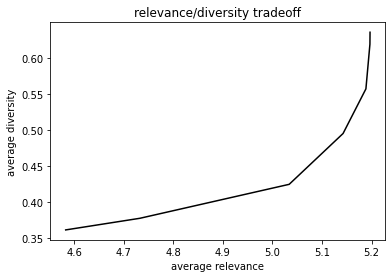

In [82]:
plt.plot(xs, ys, color='k')
plt.xlabel("average relevance")
plt.ylabel("average diversity")
plt.title("relevance/diversity tradeoff")
plt.show()


### 10.2

Concentration effects

In [83]:
data = []
for x in parse(os.path.join(dataDir, "goodreads_reviews_comics_graphic.json.gz")):
    del x['review_text']
    data.append(x)


In [84]:
random.shuffle(data)


In [85]:
userIDs, itemIDs = {}, {}
revUIDs, revIIDs = {}, {}
for d in data:
    u, i = d['user_id'], d['book_id']
    if not u in userIDs:
        userIDs[u] = len(userIDs)
        revUIDs[userIDs[u]] = u
    if not i in itemIDs:
        itemIDs[i] = len(itemIDs)
        revIIDs[itemIDs[i]] = i


In [86]:
nUsers, nItems = len(userIDs), len(itemIDs)
nUsers, nItems


(59347, 89311)

In [87]:
Xiu = scipy.sparse.lil_matrix((nItems, nUsers))
for d in data:
    Xiu[itemIDs[d['book_id']], userIDs[d['user_id']]] = 1

Xui = scipy.sparse.csr_matrix(Xiu.T)


In [88]:
model = bpr.BayesianPersonalizedRanking(factors=5, use_gpu=False)
model.fit(Xiu)


  0%|          | 0/100 [00:00<?, ?it/s]

Measure concentration in terms of the Gini coefficient

In [89]:
interactionTuples = []
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)

for d in data:
    u, i = d['user_id'], d['book_id']
    interactionTuples.append((userIDs[u], itemIDs[i]))
    itemsPerUser[userIDs[u]].append(itemIDs[i])
    usersPerItem[itemIDs[i]].append(userIDs[u])


In [90]:
recommendationTuples1 = []
for u in range(len(userIDs)):
    A = model.recommend(u, Xui, N=len(itemsPerUser[u]))
    for i, sc in A:
        recommendationTuples1.append((u, i))


In [91]:
countsPerItemI = defaultdict(int)
countsPerItemR1 = defaultdict(int)

for u, i in interactionTuples:
    countsPerItemI[i] += 1

for u, i in recommendationTuples1:
    countsPerItemR1[i] += 1


Aplly a small penalty for items that are highly recommended (resulting a reduction of concentration). This is essentially just a simple re-ranking strategy.

In [92]:
recommendationTuples2 = []
for u in range(len(userIDs)):
    N = len(itemsPerUser[u])
    A = model.recommend(u, Xui, max(N, 100))
    Aadj = []
    for i, sc in A:
        # Rerank by penalizing highly-recommended items
        Aadj.append((sc - 0.1*countsPerItemR1[i], i))
    Aadj.sort(reverse=True)
    for sc, i in Aadj[:N]:
        recommendationTuples2.append((u, i))


In [93]:
countsPerItemR2 = defaultdict(int)

for u, i in recommendationTuples2:
    countsPerItemR2[i] += 1


Compare interaction data, recommendations, and "corrected" recommendations in terms of concentration

In [94]:
sortPopularI = [(countsPerItemI[i], i) for i in countsPerItemI]
sortPopularR1 = [(countsPerItemR1[i], i) for i in countsPerItemR1]
sortPopularR2 = [(countsPerItemR2[i], i) for i in countsPerItemR2]


In [95]:
sortPopularI.sort(reverse=True)
sortPopularR1.sort(reverse=True)
sortPopularR2.sort(reverse=True)


In [96]:
gini([x[0] for x in sortPopularI])


0.7208343510172622

In [97]:
gini([x[0] for x in sortPopularR1])


0.7816414195538576

In [98]:
gini([x[0] for x in sortPopularR2])


0.6837148130870416

Ultimately we got a model with lower concentration than the original data. Could adjust the penalty term to control the concentration amount.

### 10.3

Measure parity in terms of beer ABV (alcohol level). Do high- (or low-) alcohol items tend to get recommended more than we would expect from interaction data?

In [99]:
userIDs = {}
itemIDs = {}
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
styles = {}
beerNames = {}
interactions = []

atr = dict()

for d in parse(os.path.join(dataDir, "beer.json.gz")):
    if not 'user/gender' in d:
        continue
    try:
        a = d['beer/ABV'] > 7.5
    except Exception as e:
        continue
    u = d['user/profileName']
    i = d['beer/beerId']
    r = d['review/overall']
    styles[i] = d['beer/style']
    beerNames[i] = d['beer/name']
    if not u in userIDs:
        userIDs[u] = len(userIDs)
    if not i in itemIDs:
        itemIDs[i] = len(itemIDs)
    itemsPerUser[userIDs[u]].append(i)
    usersPerItem[itemIDs[i]].append(u)
    interactions.append((u, i, r))
    atr[itemIDs[i]] = a


In [100]:
nUsers, nItems = len(userIDs), len(itemIDs)
nUsers, nItems


(8402, 34866)

Start by training a BPR model (using the implicit library)

In [101]:
Xiu = scipy.sparse.lil_matrix((nItems, nUsers))
for (u, i, r) in interactions:
    Xiu[itemIDs[i], userIDs[u]] = 1

Xui = scipy.sparse.csr_matrix(Xiu.T)


In [102]:
model = bpr.BayesianPersonalizedRanking(factors=5, use_gpu=False)
model.fit(Xiu)


  0%|          | 0/100 [00:00<?, ?it/s]

Frequency of positive (high alcohol) versus negative (low alcohol) among interactions

In [103]:
apos, aneg = 0, 0

for (u, i, r) in interactions:
    if atr[itemIDs[i]]:
        apos += 1
    else:
        aneg += 1

apos, aneg


(216825, 395700)

Frequency among recommendations (low alcohol items end up being slightly over-recommended)

In [104]:
apos, aneg = 0, 0

for u in range(len(userIDs)):
    A = model.recommend(u, Xui, N=len(itemsPerUser[u]))
    for i, sc in A:
        if atr[i]:
            apos += 1
        else:
            aneg += 1

apos, aneg


(199317, 413208)

As in 10.2, correct using a re-ranking strategy with a simple penalty term (in this case encouraging high-alcohol items to be recommended). Again this could be adjusted to achieve the desired calibration.

In [105]:
apos, aneg = 0, 0

for u in range(len(userIDs)):
    N = len(itemsPerUser[u])
    A = model.recommend(u, Xui, N*2)
    Aadj = []
    for i, sc in A:
        Aadj.append((sc + 0.1*atr[i], i))
    Aadj.sort(reverse=True)
    for sc, i in Aadj[:N]:
        if atr[i]:
            apos += 1
        else:
            aneg += 1

apos, aneg


(235361, 377164)